### Получим данные

In [43]:
import scipy.stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from scipy.stats import poisson
from scipy.stats import ttest_ind

In [44]:
df = pd.read_csv("MERGE_TABLE_STORE_4600.csv", sep=";")

### Пропуски в flag_promo

In [45]:
df.flg_spromo.isnull().sum()

0

In [46]:
df.flg_spromo.value_counts()

0    13594213
1       23101
Name: flg_spromo, dtype: int64

### Получим список товаров, по которым больше всего данных:

In [47]:
id_list = df.product_id.value_counts().nlargest(40).index.tolist()

In [48]:
print(id_list)

[555800, 616400, 564900, 582700, 404500, 589400, 582800, 1518900, 835000, 587400, 617400, 819800, 1843100, 631500, 7562300, 11637400, 3539700, 3540400, 12906800, 4095600, 886100, 4212800, 706600, 9339400, 589700, 625700, 560100, 559800, 490400, 1617800, 744200, 720500, 4285500, 615200, 1453400, 4043300, 571300, 808700, 101300, 6783400]


### Выберем только нужные товары и приводим даты к верному формату, получим dataframe для модели:

In [49]:
df_model = df[df.product_id.isin(id_list)]

Смотрим на тот же флаг промо

In [50]:
df_model.flg_spromo.value_counts()

0    54421
1     1891
Name: flg_spromo, dtype: int64

In [51]:
df_model.loc[:, "curr_date"] = pd.to_datetime(df_model.curr_date)

/home/alexander/PythonProjects/MO/venb/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


### Посчитаем спрос с помощью функций для него

In [52]:
import restore_demand_beta as dem

In [53]:
df_temp = dem.restore_demand(df_model, id_list[0], store_id=4600, method="promo")

In [54]:
df_temp

,product_id,store_id,flg_spromo,s_qty,stock,lambda,demand
2016-01-02,555800,4600,0,1.0,0.0,1.501818,1.0
2016-01-03,555800,4600,0,1.0,-1.0,1.501818,2.0
2016-01-04,555800,4600,0,1.0,-2.0,1.501818,1.0
2016-01-05,555800,4600,0,NaN,-3.0,1.501818,1.0
2016-01-06,555800,4600,0,1.0,-3.0,1.501818,2.0
...,...,...,...,...,...,...,...
2019-12-26,555800,4600,1,NaN,9.0,1.501818,4.0
2019-12-27,555800,4600,1,NaN,9.0,1.501818,0.0
2019-12-28,555800,4600,1,NaN,9.0,1.501818,1.0
2019-12-29,555800,4600,1,NaN,9.0,1.501818,3.0


### Тесты и визуализация:

In [55]:
import ipywidgets as widgets
from IPython.display import display, clear_output

In [56]:
_sku_list = df_model.product_id.unique().tolist()
_store_list = df.store_id.unique().tolist()

dropdown_store = widgets.Dropdown(
    options=_store_list,
    value=_store_list[0],
    description='Store ID:',
    disabled=False,
)

dropdown_sku = widgets.Dropdown(
    options=_sku_list,
    value=582700,
    description='SKU ID:',
    disabled=False,
)

_dates = pd.to_datetime(df_model.curr_date.unique())
_options = [(d.strftime('%d.%m.%Y'), d) for d in _dates if d.weekday() == 0]
range_date = widgets.SelectionRangeSlider(
    options=_options,
    index=(0,len(_options)-1),
    description='Date',
    disabled=False,
    layout=widgets.Layout(width='auto')
)

button_plot = widgets.Button(
    description='Plot',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check'
)

def plot(b):
    df_predicted = dem.restore_demand(
        df_model, dropdown_sku.value, dropdown_store.value, method="promo"
    )

    # Demand predicted by sampling function
    y1 = df_predicted[
        (range_date.value[0] <= df_predicted.index)
        & (df_predicted.index < range_date.value[1])
    ].demand.values
    x1 = df_predicted[
        (range_date.value[0] <= df_predicted.index)
        & (df_predicted.index < range_date.value[1])
    ].index.values

    df_predicted.s_qty.fillna(method="ffill", inplace=True)

    # Real sales
    y2 = df_predicted[
        (range_date.value[0] <= df_predicted.index)
        & (df_predicted.index < range_date.value[1])
    ].s_qty.values
    x2 = df_predicted[
        (range_date.value[0] <= df_predicted.index)
        & (df_predicted.index < range_date.value[1])
    ].index.values

    # Deficit periods
    y3 = df_predicted[
        (range_date.value[0] <= df_predicted.index)
        & (df_predicted.index < range_date.value[1])
        & (
            (df_predicted.s_qty == df_predicted.stock)
            | (0 >= df_predicted.stock)
        )
    ].s_qty.values
    x3 = df_predicted[
        (range_date.value[0] <= df_predicted.index)
        & (df_predicted.index < range_date.value[1])
        & (
            (df_predicted.s_qty == df_predicted.stock)
            | (0 >= df_predicted.stock)
        )
    ].index.values

    # Finding promo periods
    x6 = df_predicted[
        (df_predicted.index >= range_date.value[0])
        & (df_predicted.index < range_date.value[1])
        & (df_predicted["flg_spromo"] == 1)
    ].index.values
    y6 = [0] * len(x6)

    # Вывод
    clear_output()
    display(dropdown_store, dropdown_sku, range_date, button_plot)

    plt.figure(figsize=(15, 7))

    plt.plot(x1, y1, label="Восстановленный спрос", c="black", alpha=0.25)

    plt.plot(x2, y2, label="Реальные продажи", c="blue", alpha=0.5)
    plt.scatter(x2, y2, marker="x", c="blue")

    for i in range(len(x3)):
        if i and (x3[i] - x3[i - 1]) / np.timedelta64(1, "D") == 1:
            plt.axvspan(x3[i - 1], x3[i], facecolor="r", alpha=0.25)
        elif (
            i == len(x3) - 1
            and not (x3[i] - x3[i - 1]) / np.timedelta64(1, "D") == 1
        ):
            plt.axvspan(
                x3[i],
                x3[i] + np.timedelta64(1, "D"),
                facecolor="r",
                alpha=0.25,
            )

    for i in range(len(x6)):
        if i and (x6[i] - x6[i - 1]) / np.timedelta64(1, "D") == 1:
            plt.axvspan(x6[i - 1], x6[i], facecolor="g", alpha=0.25)
        elif (
            i == len(x6) - 1
            and not (x6[i] - x6[i - 1]) / np.timedelta64(1, "D") == 1
        ):
            plt.axvspan(
                x6[i],
                x6[i] + np.timedelta64(1, "D"),
                facecolor="g",
                alpha=0.25,
            )

    plt.ylabel("Amount of desired products", fontsize="12")
    plt.xlabel("Dates", fontsize="12")
    plt.title(
        f"Demand and real sales "
        f"[{range_date.value[0].strftime('%d.%m.%Y')}"
        f"-{range_date.value[1].strftime('%d.%m.%Y')}]",
        fontsize="16",
    )
    plt.legend()
    plt.show()


button_plot.on_click(plot)

In [57]:
display(dropdown_store, dropdown_sku, range_date, button_plot)

Dropdown(description='Store ID:', options=(4600,), value=4600)

Dropdown(description='SKU ID:', index=8, options=(101300, 404500, 490400, 555800, 559800, 560100, 564900, 5713…

SelectionRangeSlider(description='Date', index=(0, 208), layout=Layout(width='auto'), options=(('04.01.2016', …

Button(description='Plot', icon='check', style=ButtonStyle(), tooltip='Click me')

In [98]:
_sku_list = df_model.product_id.unique().tolist()
_store_list = df.store_id.unique().tolist()


_dates = pd.to_datetime(df_model.curr_date.unique())
_options = [(d.strftime("%d.%m.%Y"), d) for d in _dates if d.weekday() == 0]

dropdown_store = widgets.Dropdown(
    options=_store_list,
    value=_store_list[0],
    description="Store ID:",
    disabled=False,
)

_dates = pd.to_datetime(df_model.curr_date.unique())
_options = [(d.strftime("%d.%m.%Y"), d) for d in _dates if d.weekday() == 0]
range_date = widgets.SelectionRangeSlider(
    options=_options,
    index=(0, len(_options) - 1),
    description="Date",
    disabled=False,
    layout=widgets.Layout(width="auto"),
)

button_plot = widgets.Button(
    description="Plot",
    disabled=False,
    button_style="",  # 'success', 'info', 'warning', 'danger' or ''
    tooltip="Click me",
    icon="check",
)


def plot_sum(b):
    y1_f, y2_f, y3_f, y6_f = {}, {}, {}, {}
    
    for sku in _sku_list:
        df_predicted = dem.restore_demand(
            df_model, sku, dropdown_store.value, method="promo"
        )
        df_predicted.s_qty.fillna(method='ffill', inplace=True)

        # Demand predicted by sampling function
        x1 = df_predicted[
            (range_date.value[0] <= df_predicted.index)
            & (df_predicted.index < range_date.value[1])
        ]
        
        temp1 = dict(zip(x1.reset_index()["index"].values, x1["demand"].values))
        y1_f = {k: np.nansum(temp1.get(k, 0) + y1_f.get(k, 0)) for k in set(temp1) | set(y1_f)}

        # Real sales
        temp2 = dict(zip(x1.reset_index()["index"].values, x1["s_qty"].values))
        y2_f = {k: np.nansum(temp2.get(k, 0) + y2_f.get(k, 0)) for k in set(temp2) | set(y2_f)}

        # Deficit periods
        y3 = df_predicted[
            (range_date.value[0] <= df_predicted.index)
            & (df_predicted.index < range_date.value[1])
            & (
                (df_predicted.s_qty == df_predicted.stock)
                | (0 >= df_predicted.stock)
            )
        ].s_qty.values
        y3 = y3 * 0
        y3 = y3 + 1
        
        x3 = df_predicted[
            (range_date.value[0] <= df_predicted.index)
            & (df_predicted.index < range_date.value[1])
            & (
                (df_predicted.s_qty == df_predicted.stock)
                | (0 >= df_predicted.stock)
            )
        ]
        
        temp3 = dict(zip(x3.index.values, y3))
        y3_f = {k: np.nansum(temp3.get(k, 0) + y3_f.get(k, 0)) for k in set(temp3) | set(y3_f)}

        # Finding promo periods
        x6 = df_predicted[
            (df_predicted.index >= range_date.value[0])
            & (df_predicted.index < range_date.value[1])
            & (df_predicted["flg_spromo"] == 1)
        ].index.values
        y6 = [1] * len(x6)
        
        temp4 = dict(zip(x6, y6))
        y6_f = {k: np.nansum(temp4.get(k, 0) + y6_f.get(k, 0)) for k in set(temp4) | set(y6_f)}




    lists = sorted(y1_f.items()) # sorted by key, return a list of tuples
    x1, y1_f = zip(*lists)
    
    lists = sorted(y2_f.items()) # sorted by key, return a list of tuples
    x2, y2_f = zip(*lists)
    
    lists = sorted(y3_f.items()) # sorted by key, return a list of tuples
    x3, y3_f = zip(*lists)
    
    lists = sorted(y6_f.items()) # sorted by key, return a list of tuples
    if lists != []:
        x6, y6_f = zip(*lists)
    
    # Вывод
    clear_output()
    display(dropdown_store, range_date, button_plot)

    fig, host = plt.subplots(figsize=(15,7))
    par1 = host.twinx()
    par2 = host.twinx()
    
    host.set_ylabel("Amount of desired products", fontsize="12")
    host.set_xlabel("Dates", fontsize="12")
    
    #par1.set_ylim(0, 45)
    par1.set_ylabel("Deficit days", fontsize="12")
    par2.spines['right'].set_position(('outward', 60))
    par2.set_ylabel("Promo days", fontsize="12")
    par1.yaxis.label.set_color("red")
    par2.yaxis.label.set_color("lightgreen")

    p1, = host.plot(x1, y1_f, label="Суммарный восстановленный спрос", c="black", alpha=0.25)

    p2, = host.plot(x2, y2_f, label="Суммарно реальных продаж", c="blue", alpha=0.5)
    host.scatter(x2, y2_f, marker="x", c="blue")
    
    p3, = par1.plot(x3, y3_f, label="Кол-во дефицитных дней", c="red", alpha=0.2)
    par1.scatter(x3, y3_f, marker=".", c="red")
    lns = [p1, p2, p3]
    
    if lists != []:
        p4, = par2.plot(x6, y6_f, label="Промо дни", c="green", alpha=0.2)
        par2.scatter(x6, y6_f, marker=".", c="green")
        lns.append(p4)

#     for i in range(len(x3)):
#         if i and (x3[i] - x3[i - 1]) / np.timedelta64(1, "D") == 1:
#             plt.axvspan(x3[i - 1], x3[i], facecolor="r", alpha=0.25)
#         elif (
#             i == len(x3) - 1
#             and not (x3[i] - x3[i - 1]) / np.timedelta64(1, "D") == 1
#         ):
#             plt.axvspan(
#                 x3[i],
#                 x3[i] + np.timedelta64(1, "D"),
#                 facecolor="r",
#                 alpha=0.25,
#             )

#     for i in range(len(x6)):
#         if i and (x6[i] - x6[i - 1]) / np.timedelta64(1, "D") == 1:
#             plt.axvspan(x6[i - 1], x6[i], facecolor="g", alpha=0.25)
#         elif (
#             i == len(x6) - 1
#             and not (x6[i] - x6[i - 1]) / np.timedelta64(1, "D") == 1
#         ):
#             plt.axvspan(
#                 x6[i],
#                 x6[i] + np.timedelta64(1, "D"),
#                 facecolor="g",
#                 alpha=0.25,
#             )

    host.legend(handles=lns, loc='best')
    host.set_title(
        f"Demand and real sales for promo days "
        f"[{range_date2.value[0].strftime('%d.%m.%Y')}"
        f"-{range_date2.value[1].strftime('%d.%m.%Y')}]",
        fontsize="16",
    )
    plt.show()


button_plot.on_click(plot_sum)

In [99]:
_sku_list = df_model.product_id.unique().tolist()
_store_list = df.store_id.unique().tolist()


_dates = pd.to_datetime(df_model.curr_date.unique())
_options = [(d.strftime("%d.%m.%Y"), d) for d in _dates if d.weekday() == 0]

dropdown_store = widgets.Dropdown(
    options=_store_list,
    value=_store_list[0],
    description="Store ID:",
    disabled=False,
)

_dates = pd.to_datetime(df_model.curr_date.unique())
_options = [(d.strftime("%d.%m.%Y"), d) for d in _dates if d.weekday() == 0]
range_date = widgets.SelectionRangeSlider(
    options=_options,
    index=(0, len(_options) - 1),
    description="Date",
    disabled=False,
    layout=widgets.Layout(width="auto"),
)

button_plot_second = widgets.Button(
    description="Plot",
    disabled=False,
    button_style="",  # 'success', 'info', 'warning', 'danger' or ''
    tooltip="Click me",
    icon="check",
)


def plot_sum_window(b):
    y1_f, y2_f, y3_f, y6_f = {}, {}, {}, {}
    
    for sku in _sku_list:
        df_predicted = dem.restore_demand(
            df_model, sku, dropdown_store.value, method="window"
        )
        df_predicted.s_qty.fillna(method='ffill', inplace=True)

        # Demand predicted by sampling function
        x1 = df_predicted[
            (range_date.value[0] <= df_predicted.index)
            & (df_predicted.index < range_date.value[1])
        ]
        
        temp1 = dict(zip(x1.reset_index()["index"].values, x1["demand"].values))
        y1_f = {k: np.nansum(temp1.get(k, 0) + y1_f.get(k, 0)) for k in set(temp1) | set(y1_f)}

        # Real sales
        temp2 = dict(zip(x1.reset_index()["index"].values, x1["s_qty"].values))
        y2_f = {k: np.nansum(temp2.get(k, 0) + y2_f.get(k, 0)) for k in set(temp2) | set(y2_f)}

        # Deficit periods
        y3 = df_predicted[
            (range_date.value[0] <= df_predicted.index)
            & (df_predicted.index < range_date.value[1])
            & (
                (df_predicted.s_qty == df_predicted.stock)
                | (0 >= df_predicted.stock)
            )
        ].s_qty.values
        y3 = y3 * 0
        y3 = y3 + 1
        
        x3 = df_predicted[
            (range_date.value[0] <= df_predicted.index)
            & (df_predicted.index < range_date.value[1])
            & (
                (df_predicted.s_qty == df_predicted.stock)
                | (0 >= df_predicted.stock)
            )
        ]
        
        temp3 = dict(zip(x3.index.values, y3))
        y3_f = {k: np.nansum(temp3.get(k, 0) + y3_f.get(k, 0)) for k in set(temp3) | set(y3_f)}

        # Finding promo periods
        x6 = df_predicted[
            (df_predicted.index >= range_date.value[0])
            & (df_predicted.index < range_date.value[1])
            & (df_predicted["flg_spromo"] == 1)
        ].index.values
        y6 = [1] * len(x6)
        
        temp4 = dict(zip(x6, y6))
        y6_f = {k: np.nansum(temp4.get(k, 0) + y6_f.get(k, 0)) for k in set(temp4) | set(y6_f)}




    lists = sorted(y1_f.items()) # sorted by key, return a list of tuples
    x1, y1_f = zip(*lists)
    
    lists = sorted(y2_f.items()) # sorted by key, return a list of tuples
    x2, y2_f = zip(*lists)
    
    lists = sorted(y3_f.items()) # sorted by key, return a list of tuples
    x3, y3_f = zip(*lists)
    
    lists = sorted(y6_f.items()) # sorted by key, return a list of tuples
    if lists != []:
        x6, y6_f = zip(*lists)
    
    # Вывод
    clear_output()
    display(dropdown_store, range_date, button_plot_second)
    
    fig, host = plt.subplots(figsize=(15,7))
    par1 = host.twinx()
    par2 = host.twinx()
    
    host.set_ylabel("Amount of desired products", fontsize="12")
    host.set_xlabel("Dates", fontsize="12")
    
    #par1.set_ylim(0, 45)
    par1.set_ylabel("Deficit days", fontsize="12")
    par2.spines['right'].set_position(('outward', 60))
    par2.set_ylabel("Promo days", fontsize="12")
    par1.yaxis.label.set_color("red")
    par2.yaxis.label.set_color("lightgreen")

    p1, = host.plot(x1, y1_f, label="Суммарный восстановленный спрос", c="black", alpha=0.25)

    p2, = host.plot(x2, y2_f, label="Суммарно реальных продаж", c="blue", alpha=0.5)
    host.scatter(x2, y2_f, marker="x", c="blue")
    
    p3, = par1.plot(x3, y3_f, label="Кол-во дефицитных дней", c="red", alpha=0.2)
    par1.scatter(x3, y3_f, marker=".", c="red")
    
    lns = [p1,p2,p3]
    
    if lists != []:
        p4, = par2.plot(x6, y6_f, label="Промо дни", c="lightgreen", alpha=0.2)
        par2.scatter(x6, y6_f, marker=".", c="lightgreen")
        lns.append(p4)

#     for i in range(len(x3)):
#         if i and (x3[i] - x3[i - 1]) / np.timedelta64(1, "D") == 1:
#             plt.axvspan(x3[i - 1], x3[i], facecolor="r", alpha=0.25)
#         elif (
#             i == len(x3) - 1
#             and not (x3[i] - x3[i - 1]) / np.timedelta64(1, "D") == 1
#         ):
#             plt.axvspan(
#                 x3[i],
#                 x3[i] + np.timedelta64(1, "D"),
#                 facecolor="r",
#                 alpha=0.25,
#             )

#     for i in range(len(x6)):
#         if i and (x6[i] - x6[i - 1]) / np.timedelta64(1, "D") == 1:
#             plt.axvspan(x6[i - 1], x6[i], facecolor="g", alpha=0.25)
#         elif (
#             i == len(x6) - 1
#             and not (x6[i] - x6[i - 1]) / np.timedelta64(1, "D") == 1
#         ):
#             plt.axvspan(
#                 x6[i],
#                 x6[i] + np.timedelta64(1, "D"),
#                 facecolor="g",
#                 alpha=0.25,
#             )

    host.legend(handles=lns, loc='best')
    host.set_title(
        f"Demand and real sales for rolling window "
        f"[{range_date2.value[0].strftime('%d.%m.%Y')}"
        f"-{range_date2.value[1].strftime('%d.%m.%Y')}]",
        fontsize="16",
    )
    plt.show()


button_plot_second.on_click(plot_sum_window)

Dropdown(description='Store ID:', options=(4600,), value=4600)

SelectionRangeSlider(description='Date', index=(41, 127), layout=Layout(width='auto'), options=(('04.01.2016',…

Button(description='Plot', icon='check', style=ButtonStyle(), tooltip='Click me')

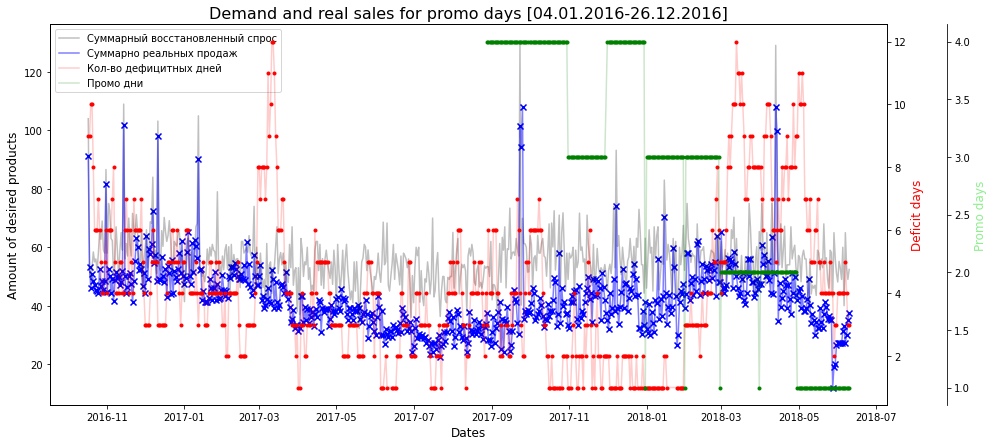

In [100]:
display(dropdown_store, range_date, button_plot)

Dropdown(description='Store ID:', options=(4600,), value=4600)

SelectionRangeSlider(description='Date', index=(41, 127), layout=Layout(width='auto'), options=(('04.01.2016',…

Button(description='Plot', icon='check', style=ButtonStyle(), tooltip='Click me')

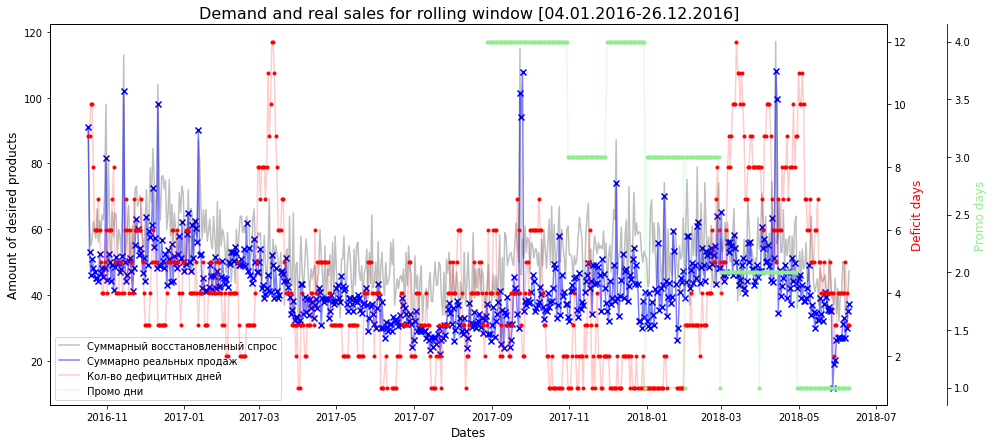

In [101]:
display(dropdown_store, range_date, button_plot_second)